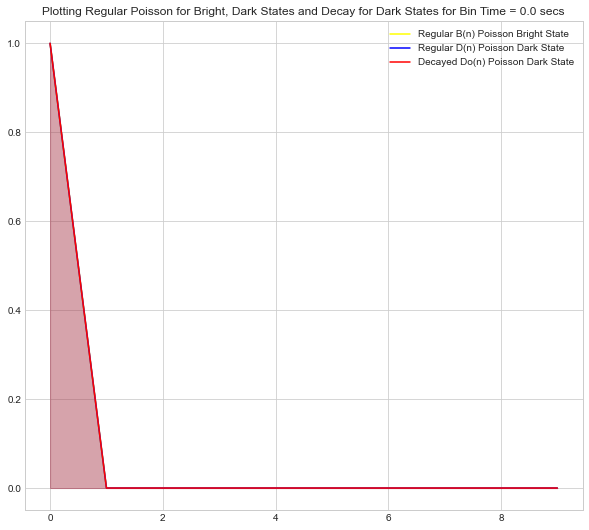

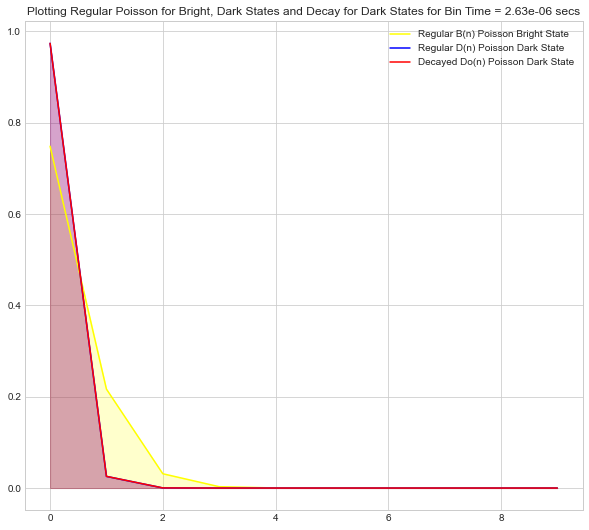

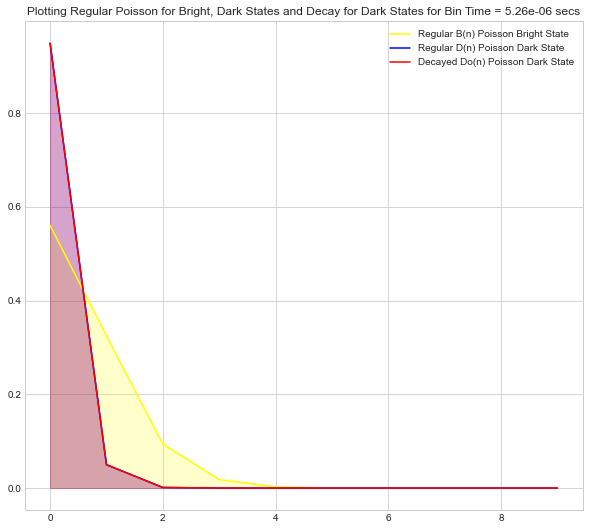

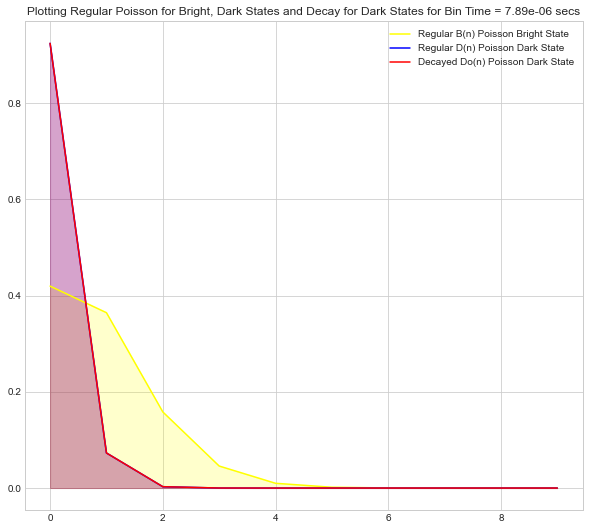

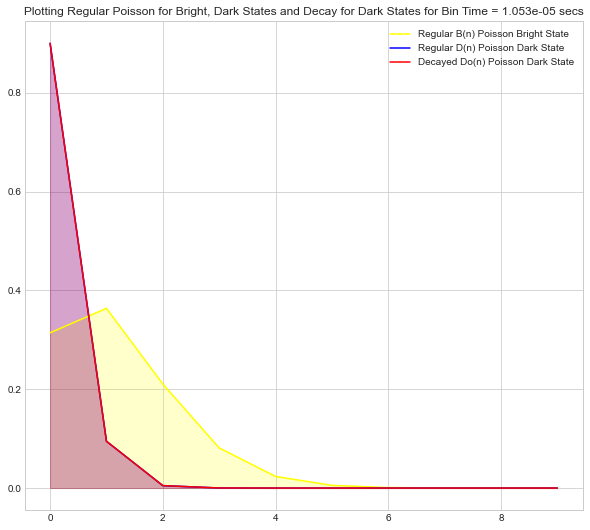

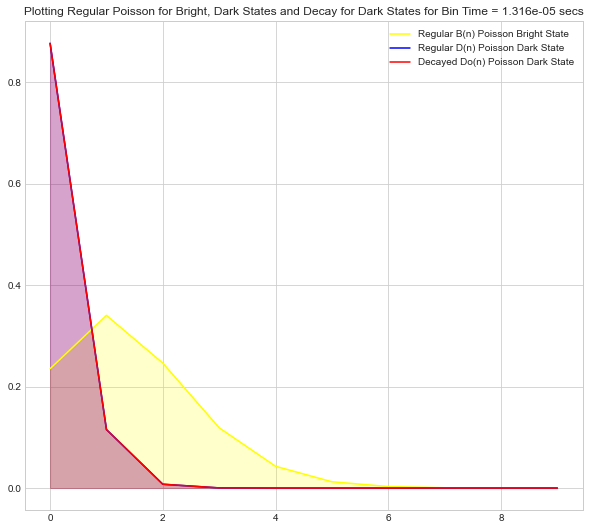

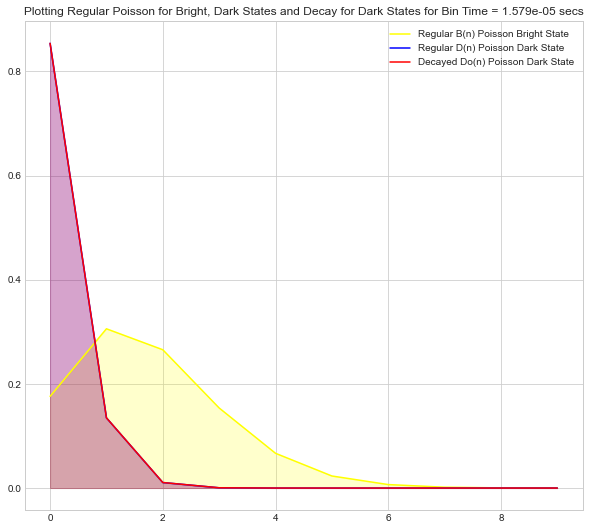

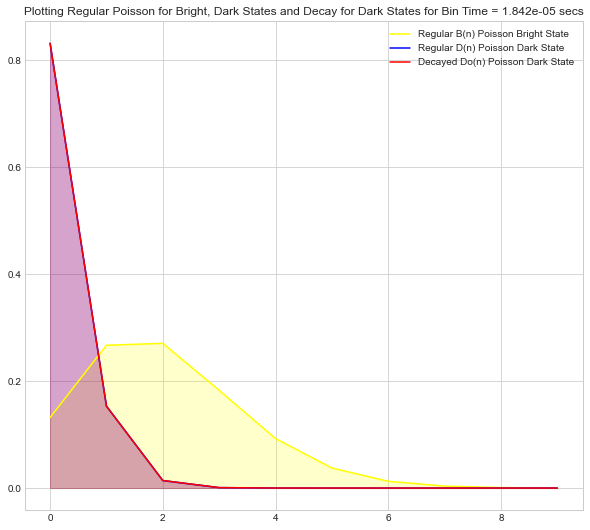

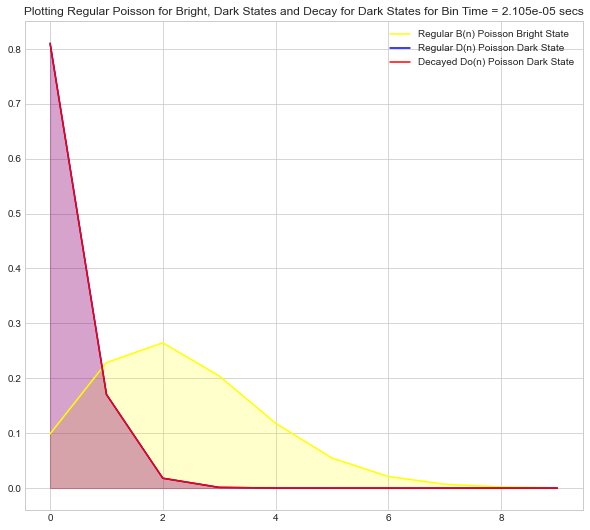

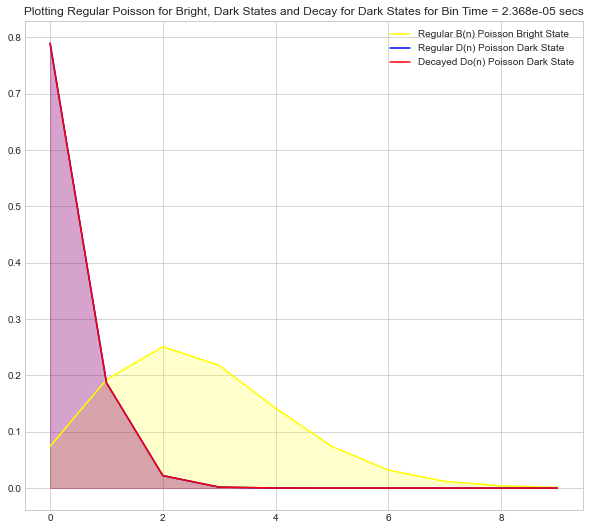

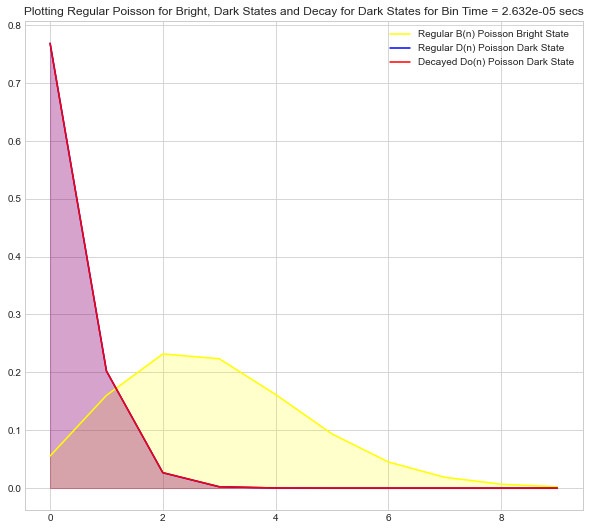

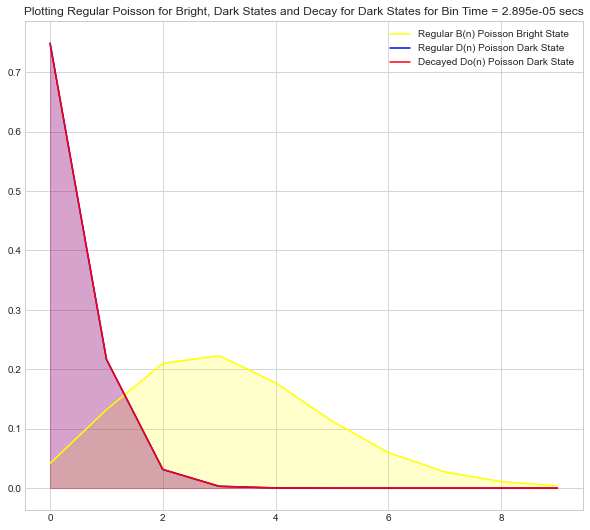

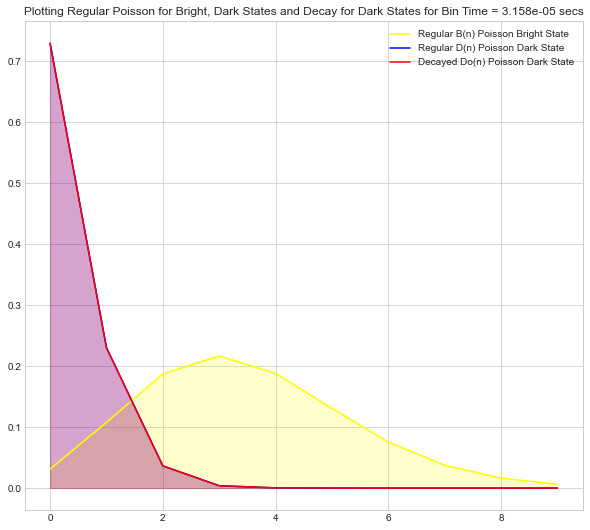

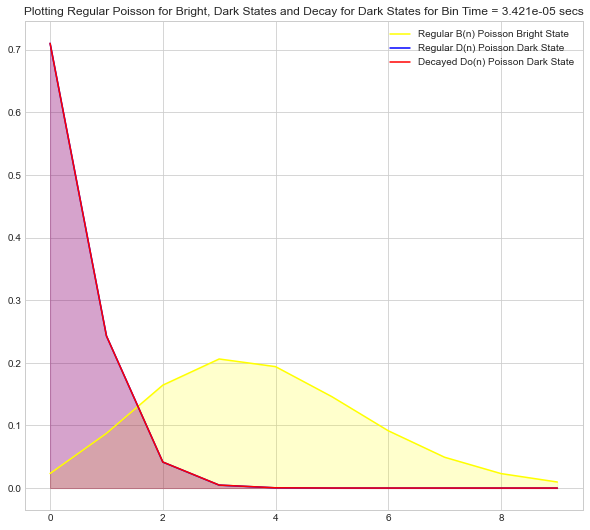

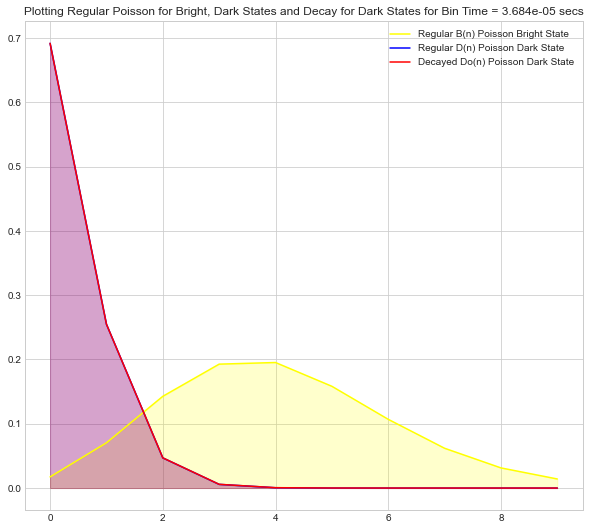

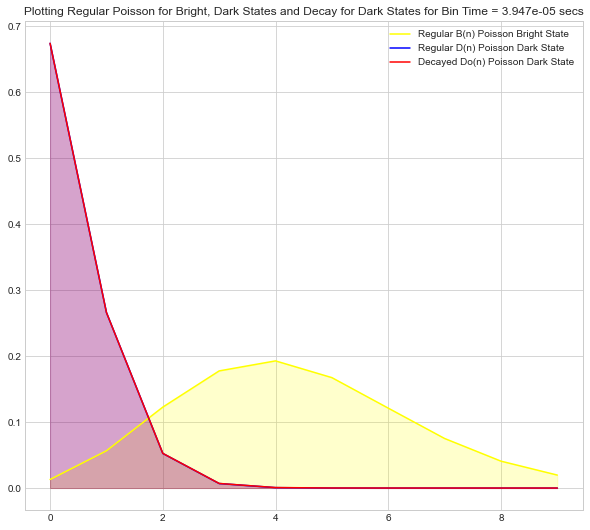

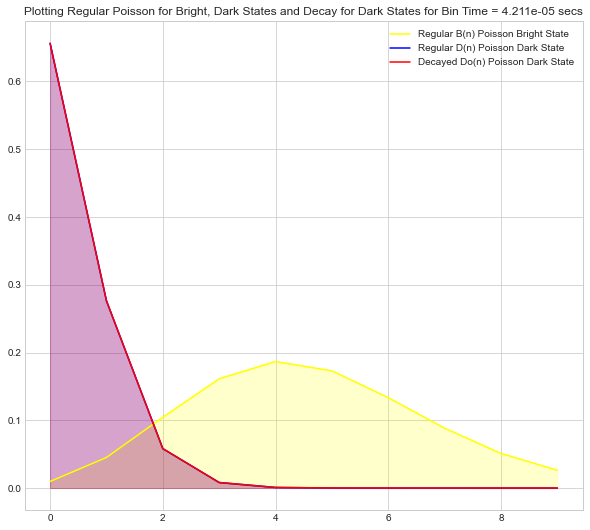

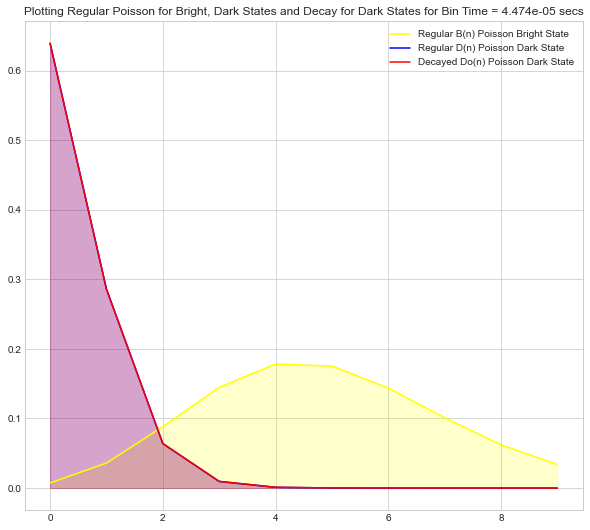

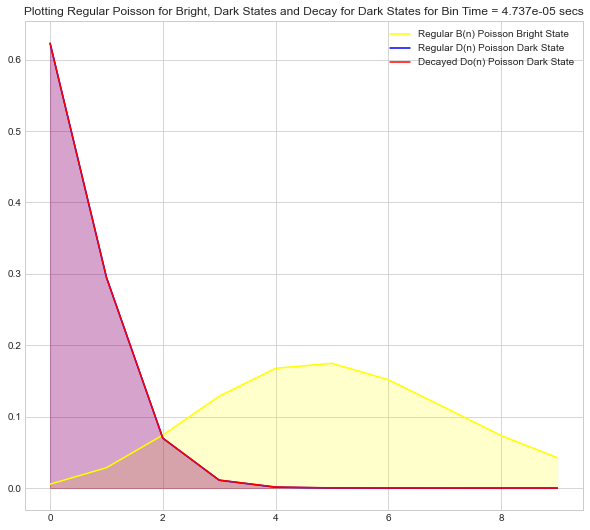

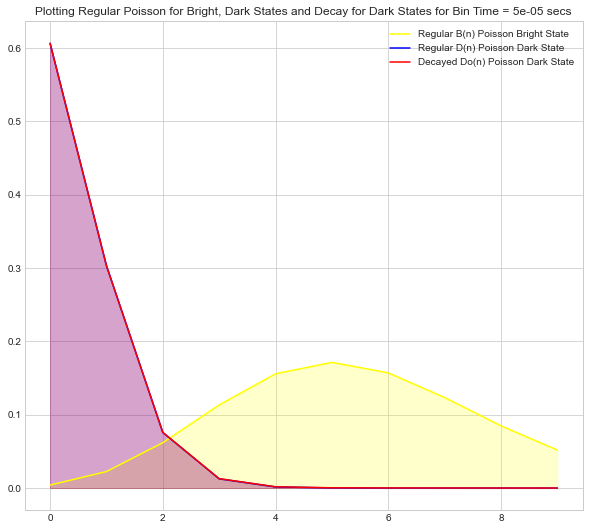

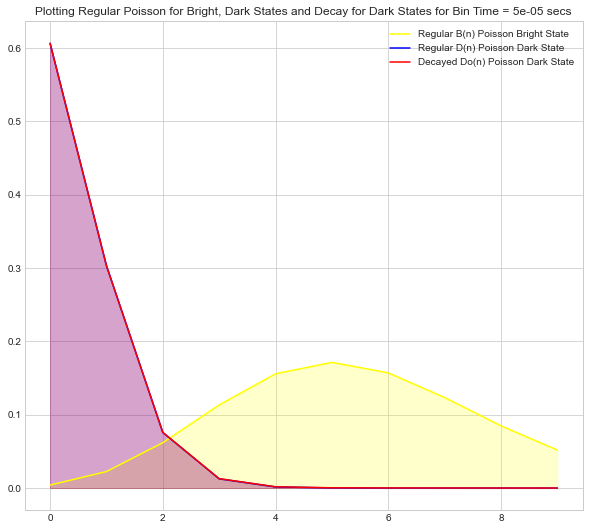

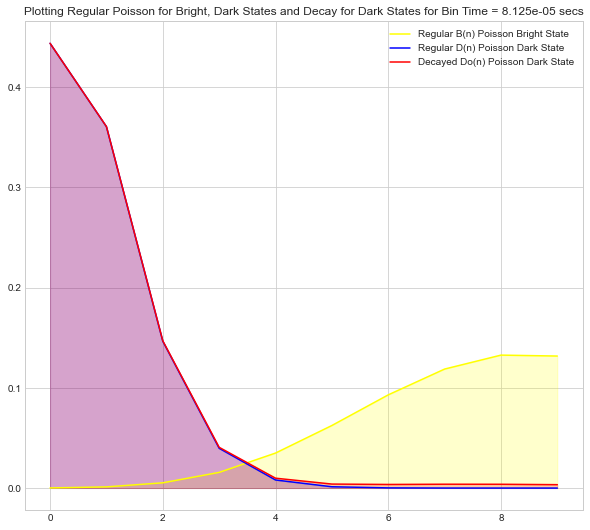

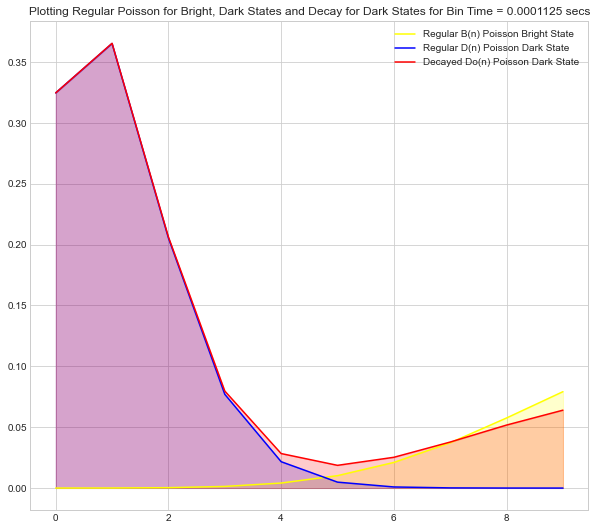

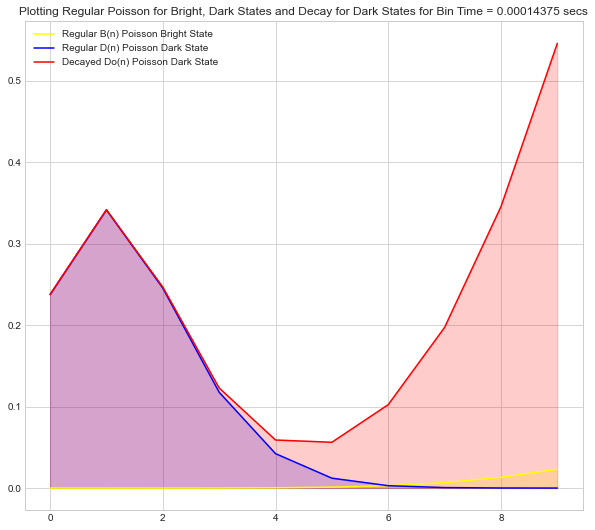

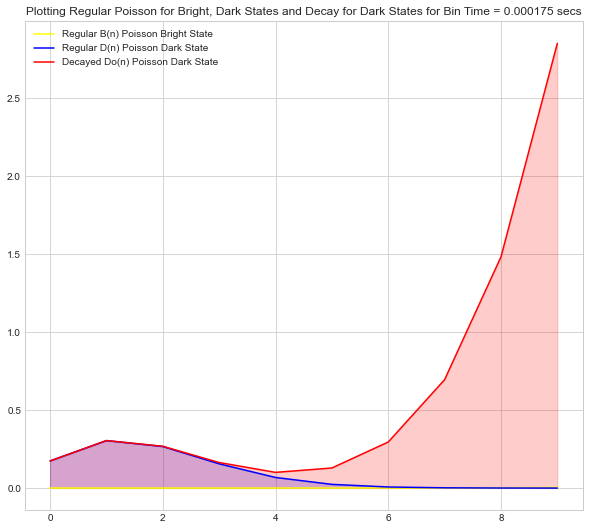

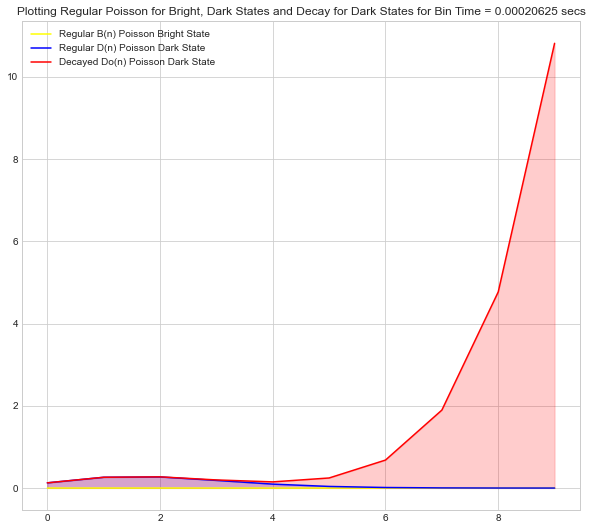

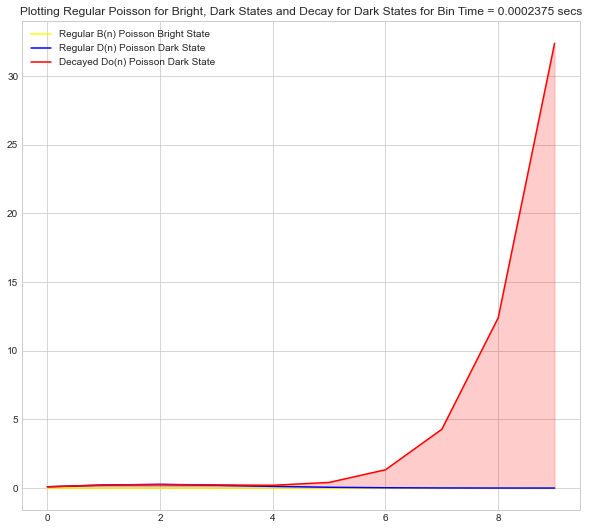

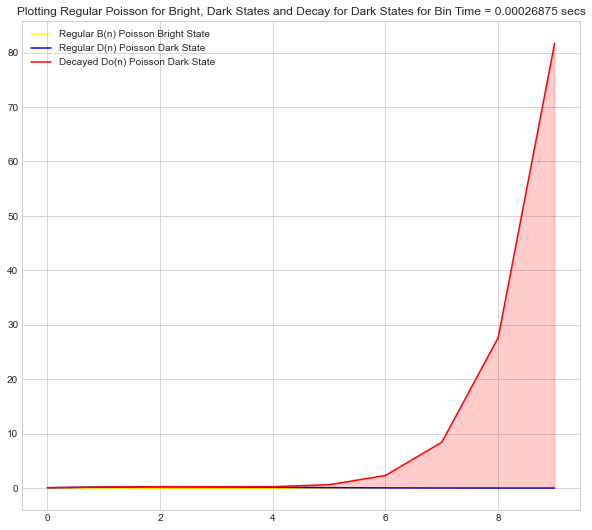

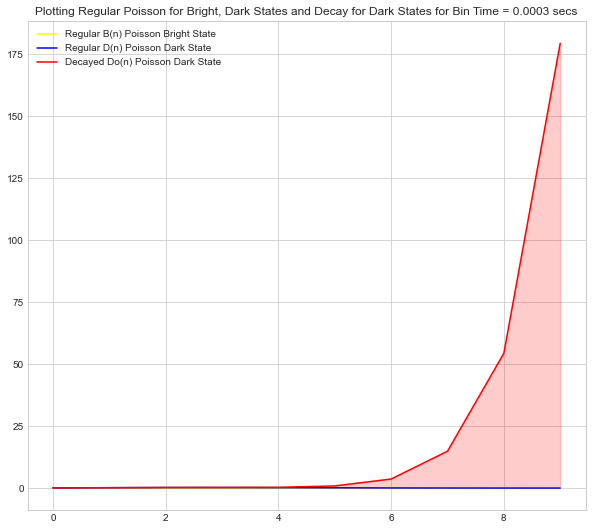

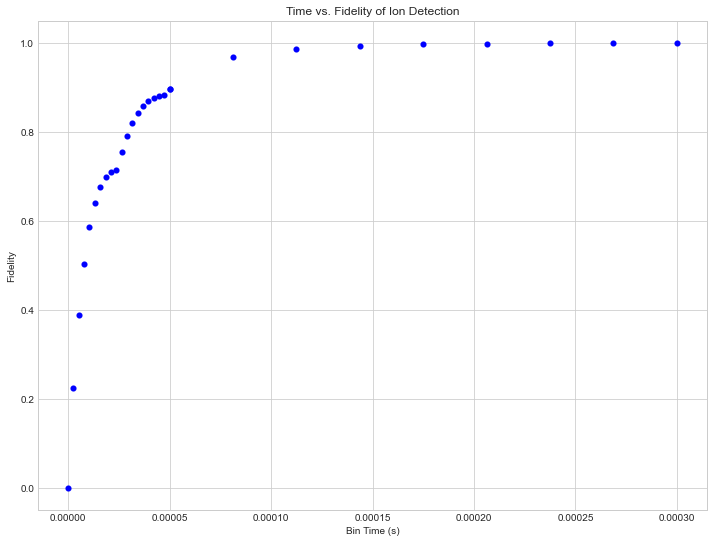

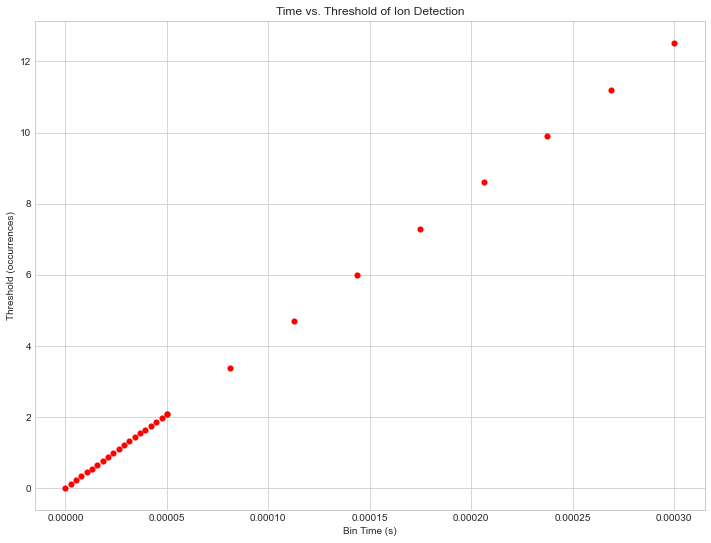

In [ ]:
# Created By  : Katharine Lundblad
# Created Date: 4/05/22
# version ='1.0'
# ---------------------------------------------------------------------------
""" Calculates bin time for a trapped-ion detector given a 
    specified fidelity or probability of predicting the occurrence
    of an ion or its dark state. Plots Fidelity vs. Time and Threshold
    vs. time, probabilities are calculated analytically"""  
# ---------------------------------------------------------------------------
# Imports numpy, math, matplotlib, scipy.special, scipy.integrate
# ---------------------------------------------------------------------------
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.special as sc
from scipy.integrate import trapz
from scipy.stats import poisson
from scipy.special import factorial, gamma

bin_times = np.linspace(0, 0.00005, 20)
bin_times = np.append(bin_times, np.linspace(0.00005, 0.001, 10))
# empty arrays for fidelities and thresholds
fidelities = np.array([])
thresholds = np.array([]) # thresholds for regular poisson
decay_thresholds = np.array([])
fidelity_time_dict = {}
thresh_time_dict = {}
poisson_B = np.array([])


R_B = float(1e5) # count rate of bright spots
R_D = float(1e4) # count rate of dark spots


tau = 1.168 # tau for decay of dark state, factor in probability ion remains in shelved state through bin time
Xo_vals = np.array([]) # array to store each value computed in the integral for the Xo integral
n_factorial_arr = np.array([])
n_decay = np.arange(0, 40, 1) # x values of n for the decayed Do(n) poisson distribution
# bin time is independent variable for fidelity and threshold functions but is a constant for poissonian probability distribution
for bin_time in bin_times:
    """
    Calculating Information for Fidelity and Threshold Calculations
    """
    Xo_vals = np.array([]) # array to store each value computed in the integral for the Xo integral
    n_factorial_arr = np.array([])
    Do_array = np.array([])
    
    lambda_mean_R_B = (R_B + R_D) * bin_time # mean of poisson distribution, probability of bright spot
    lambda_mean_R_D = R_D * bin_time         # mean of poisson distribution, probability of dark spot
    
    # threshold for considering bright state and dark state (ie. n >= thresh is bright n < thresh is dark)
    threshold = (R_B * bin_time) / math.log(1.0 + (R_B / R_D)) 
    # Portions of graph that overlap at the threshold value are calculated
    discrim_B = poisson.cdf(k = threshold, mu = lambda_mean_R_B)
    discrim_D = 1.0 - poisson.cdf(k = threshold, mu = lambda_mean_R_D)
    
    fidelity = 1.0 - (discrim_B + discrim_D) # fidelity is 1 - total discrimination error
    fidelities = np.append(fidelities, fidelity) # add new value to array
    thresholds = np.append(thresholds, threshold) 
    
    # add rounded values to dictionaries
    fidelity_time_dict[str(fidelity)] = bin_time
    thresh_time_dict[str(threshold)] = bin_time
    
    """
    Calculating Poissonian Distribution for Ion decay in dark state
    """
    
    # density of means assuming t is continuous random var
    dens_of_means = 1.0 / (R_B * tau) * math.exp((lambda_mean_R_D - ((R_D + R_B) * bin_time)) / (R_B * tau))
    
    # for every occurrence of particle, calculate factorial and find Xo term of decay equation
    for n_value in n_decay:
        n_factorial = float(math.factorial(int(n_value)))
        n_factorial_arr = np.append(n_factorial_arr, n_factorial) 
        Xo_bounds = np.arange(lambda_mean_R_D, lambda_mean_R_B, 0.01) # define bounds of dark spot mean -> bright spot mean
        neg_Xo_bounds = -1 * Xo_bounds # all values in Xo_bounds negated
        Xo_function = dens_of_means * (Xo_bounds ** n_value) * np.exp(neg_Xo_bounds) / n_factorial # function to be integrated
        
        Xo_value = trapz(Xo_function, Xo_bounds) # computes integral with discrete stepsize of 0.01
        Xo_vals = np.append(Xo_vals, Xo_value) # adds computed value to array, maps to n values

    # calculates decay term of the dark state probability 
    Decay = math.exp(-bin_time / tau) * ((R_D * bin_time) ** n_decay) * math.exp(-R_D * bin_time) / n_factorial_arr
    # adds Xo and exponential decay value and stores all decay values in an array
    for index in range(0, len(Xo_vals)):
        Do = Xo_vals[index] + Decay[index]
        Do_array = np.append(Do_array, Do) 
    
    """
    Calculating Poissonian Distribution for Dark and Bright state with no decay factor
    """
    
    # plotting poisson distribution
    poisson_B = np.exp(-lambda_mean_R_B) * np.power(lambda_mean_R_B, n_decay) / factorial(n_decay) 
    poisson_D = np.exp(-lambda_mean_R_D) * np.power(lambda_mean_R_D, n_decay) / factorial(n_decay)
    
    """
    Plotting regular poisson and then decayed poisson layered over
    """
    # plotting poisson distribution for entire range of occurrences
    r_bin_time = round(bin_time, 8) # rounding bin_time to 7 decimal places for easier reading
    plt.figure(figsize = (12, 9))
    plt.title("Plotting Regular Poisson for Bright, Dark States and Decay for Dark States for Bin Time = " + str(r_bin_time) + " secs")
    
    plt.style.use('seaborn-whitegrid')
    plt.plot(n_decay, poisson_D, c = 'blue', label = "Regular D(n) Poisson Dark State")
    plt.fill_between(x= n_decay, y1= poisson_D, where= (0 <= n_decay)&(n_decay < 40), color= "blue",
                     alpha= 0.2)

    # plots each poisson distribution corresponding to a bin time
    # print(Do_array)
    plt.plot(n_decay, Do_array, c = 'red', label = "Decayed Do(n) Poisson Dark State")
    plt.fill_between(x= n_decay, y1= Do_array, where= (0 <= n_decay)&(n_decay < 40), color= "red",
                     alpha= 0.2)
    plt.plot(n_decay, poisson_B, c = 'yellow', label = "Regular B(n) Poisson Bright State")
    plt.fill_between(x= n_decay, y1= poisson_B, where= (0 <= n_decay)&(n_decay < 40), color= "yellow",
                     alpha= 0.2)
    # finds the intersection of the decay array and the poisson_B
    idx = np.argwhere(np.diff(np.sign(Do_array - poisson_B))).flatten()
    decayed_threshold = n_decay[idx] # finds closest x integer value to the intersection of curves
    plt.plot(decayed_threshold, Do_array[idx], 'ro', label = "Threshold (" + str(decayed_threshold) + ", " + str(Do_array[idx]) + ")")
    plt.legend()
    if (len(n_decay[idx]) == 0): 
        decayed_threshold = np.array([0])
    decay_thresholds = np.append(decay_thresholds, decayed_threshold) # adding threshold to an array
    plt.show()
  

"""
Calculates Fidelity for decayed values
"""
decay_fidelities = np.array([])
n_decay = n_decay.astype(int)
for index in range(0, len(decay_thresholds)): # will use indexes of thresholds 
    # first summation of bright discrimination error
    threshold = decay_thresholds[index]
    if (threshold >= 0):
        index_thresh = int(np.where(n_decay == threshold)[0]) # location of the threshold in the n values array
    else:
        index_thresh = 0
    Bright_X_bounds = n_decay[0:index_thresh]
    bright_discrim = np.sum(poisson_B[0:index_thresh])
    # second summation of dark discrimination error
    Dark_X_bounds = n_decay[index_thresh:len(n_decay)]
    dark_discrim = np.sum(Do_array[index_thresh: len(n_decay)])
    decay_fidelity = 1.0 - (bright_discrim + dark_discrim)
    decay_fidelities = np.append(decay_fidelities, decay_fidelity)
    
    

    
"""
Plotting fidelity and threshold vs time of regular on top of decayed
"""
plt.style.use('seaborn-whitegrid')
# plotting fidelity
plt.figure(figsize = (12, 9))
plt.scatter(bin_times, fidelities, c = 'blue', linewidths = 0.1) 
plt.scatter(bin_times, decay_fidelities, c = 'black') 
plt.ylabel("Fidelity")
plt.xlabel("Bin Time (s)")
plt.title("Time vs. Fidelity of Ion Detection")

# plotting threshold
plt.figure(figsize = (12, 9))
plt.scatter(bin_times, thresholds, c = 'red', linewidths = 0.1) 
plt.scatter(bin_times, decay_thresholds, c = 'black') 
plt.ylabel("Threshold (occurrences)")
plt.xlabel("Bin Time (s)")
plt.title("Time vs. Threshold of Ion Detection")

plt.show()

"""
Plotting log of fidelity vs time past 80 percent
"""
fidelities[0] = 1
index_above_50 = int(np.where(fidelities >= 0.5)[0][0])
index_at_100 = int(np.where(fidelities <= 1.0)[-1][-1])
print(len(fidelities), len(bin_times))

dindex_above_50 = int(np.where(decay_fidelities >= 0.5)[0][0])
dindex_at_100 = int(np.where(decay_fidelities <= 1.0)[-1][-1])
large_fidelities = fidelities[int(index_above_80): int(index_at_100)]

large_decay_fidelities = decay_fidelities[int(dindex_above_50): int(dindex_at_100)]
sliced_bin_times = bin_times[int(index_above_50):int(index_at_100)]
dsliced_bin_times = bin_times[int(dindex_above_50):int(dindex_at_100)]
plt.style.use('seaborn-whitegrid')
# plotting fidelity

# for large_fidelity in large_fidelities:
#     print(math.log(large_fidelity))
plt.figure(figsize = (12, 9))
log_fidelities = np.log(large_fidelities.astype(float))
log_decay_fidelities = np.log(large_decay_fidelities.astype(float))

plt.scatter(sliced_bin_times, np.log(large_fidelities), c = 'blue', linewidths = 0.1) 
plt.scatter(dsliced_bin_times, np.log(large_decay_fidelities), c = 'black')

plt.ylabel("log(Fidelity)")
plt.xlabel("Bin Time (s)")
plt.title("Time vs. log(Fidelity) of Ion Detection")
plt.show()

"""
User Input for Fidelity printing Bin Time
"""
new_attempt = True
while (new_attempt == True): # loops however many times user wants to obtain new bin time
    input_fidelity = input("Enter input fidelity or press enter: ")
    input_thresh = input("Enter input threshold or press enter: ")

    min_fidelity_diff = 100.0 # beginning value for minimum fidelity difference to be overwritten
    return_fidelity = "0.0"

    for fidelity in fidelity_time_dict.keys(): # finds the value in dictionary closest to the value entered

        input_vs_calculated_diff = abs(float(input_fidelity) - float(fidelity)) # stores difference between inputted value and calculated value
        temp_diff = min_fidelity_diff # stores old minimum to be compared to new minimum
        min_fidelity_diff = abs(min(input_vs_calculated_diff, min_fidelity_diff)) # compares diffs from previous value and current value

        if (temp_diff != min_fidelity_diff): # if the old minimum not the same as current minimum
            return_fidelity = fidelity # if new minimum error between input and calculated is found, store this as return value

    return_time = fidelity_time_dict.get(return_fidelity) # gets given value of fidelity -> time dictionary to return


    print("Bin time for " + str(input_fidelity) + " fidelity is: " + str(return_time))
    
    # asks if user wants to input new value, y indicates yes, otherwise end running 
    ask_new = input("New bin time? (y/n): ")
    if (ask_new != "y"):
        new_attempt = False 
        
